In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os
import sys
sys.path.append('drive/MyDrive/HKUST/Comp 4641 Project')

In [3]:
import matplotlib.pyplot as plt

# Build network

In [4]:
import pandas as pd
from collections import defaultdict
import networkx as nx
from itertools import chain
import numpy as np
import random

In [5]:
def load_data(file_name):
    """
    read edges from an edge file
    """
    edges = list()
    df = pd.read_csv(file_name)
    for user_id, friends in zip(df["user_id"], df["friends"]):
        friends = eval(friends)
        for friend in friends:
            # add each friend relation as an edge
            edges.append((user_id, friend))
    edges = sorted(edges)
    
    return edges

def generate_false_edges(true_edges, num_false_edges=5):
    """
    generate false edges given true edges
    """
    nodes = list(set(chain.from_iterable(true_edges)))
    true_edges = set(true_edges)
    false_edges = set()
    
    while len(false_edges) < num_false_edges:
        # randomly sample two different nodes and check whether the pair exisit or not
        head, tail = np.random.choice(nodes, 2)
        if head != tail and ((head, tail) not in true_edges and (tail, head) not in true_edges) and ((head, tail) not in false_edges and (tail, head) not in false_edges):
            false_edges.add((head, tail))    
    false_edges = sorted(false_edges)
    
    return false_edges

def construct_graph_from_edges(edges):
    """
    generate a directed graph object given true edges
    DiGraph documentation: https://networkx.github.io/documentation/stable/reference/classes/digraph.html
    """
    # convert a list of edges {(u, v)} to a list of edges with weights {(u, v, w)}
    edges = sorted(edges)
    edge_weight = defaultdict(float)
    for e in edges:
        edge_weight[e] += 1.0
    weighed_edge_list = list()
    for e in sorted(edge_weight.keys()):
        weighed_edge_list.append((e[0], e[1], edge_weight[e]))
        
    graph = nx.Graph()
    graph.add_weighted_edges_from(weighed_edge_list)
    
    print("number of nodes:", graph.number_of_nodes())
    print("number of edges:", graph.number_of_edges())
    
    return graph

In [6]:
class visualization():

    def __init__(self, graph):
        self.graph = graph.copy()
        self.valid_edges = random.sample(self.graph.edges(), int(0.25 * self.graph.number_of_edges()))
        self.train_graph = graph.copy()
        self.train_graph.remove_edges_from(self.valid_edges)
        self.false_edges =  generate_false_edges(self.graph.edges, num_false_edges=int(0.25 * self.graph.number_of_edges()))
        self.embedding = None

    def create_embeddings(self, model):
        model()
        print(model.evaluate(self.valid_edges, self.false_edges))
        self.embedding = np.vstack([model.get_embedding(node) for node in self.graph.nodes])

    def plot(self, method=None):
        node_pos = None
        if method is None and self.embedding.shape[1] == 2:
            nodes_pos = dict(zip(self.graph.nodes, self.embedding))
        elif method is None or method == 'UMAP':
            reducer = umap.UMAP()
            reduced = reducer.fit_transform(self.embedding)
            nodes_pos = dict(zip(self.graph.nodes, reduced))
        elif method == 't-SNE':
            reducer = TSNE()
            reduced = reducer.fit_transform(self.embedding)
            nodes_pos = dict(zip(self.graph.nodes, reduced))
        elif method == 'FD':
            nodes_pos = nx.fruchterman_reingold_layout(self.graph)
        else:
            return

        plt.figure(figsize = (16, 12))
        nx.draw(self.graph, nodes_pos, node_size=100)
        plt.draw()

In [7]:
!pip install -q umap-learn
from node2vec import Deepwalk, node2vec
from sklearn.manifold import TSNE
import umap

number of nodes: 1940
number of edges: 1645
building a node2vec model...	number of walks: 19400	average walk length: 7.8985	trainig time: 4.1659
0.3135311772958957

building a node2vec model...	number of walks: 19400	average walk length: 7.8845	trainig time: 4.2557
0.2870513435274477





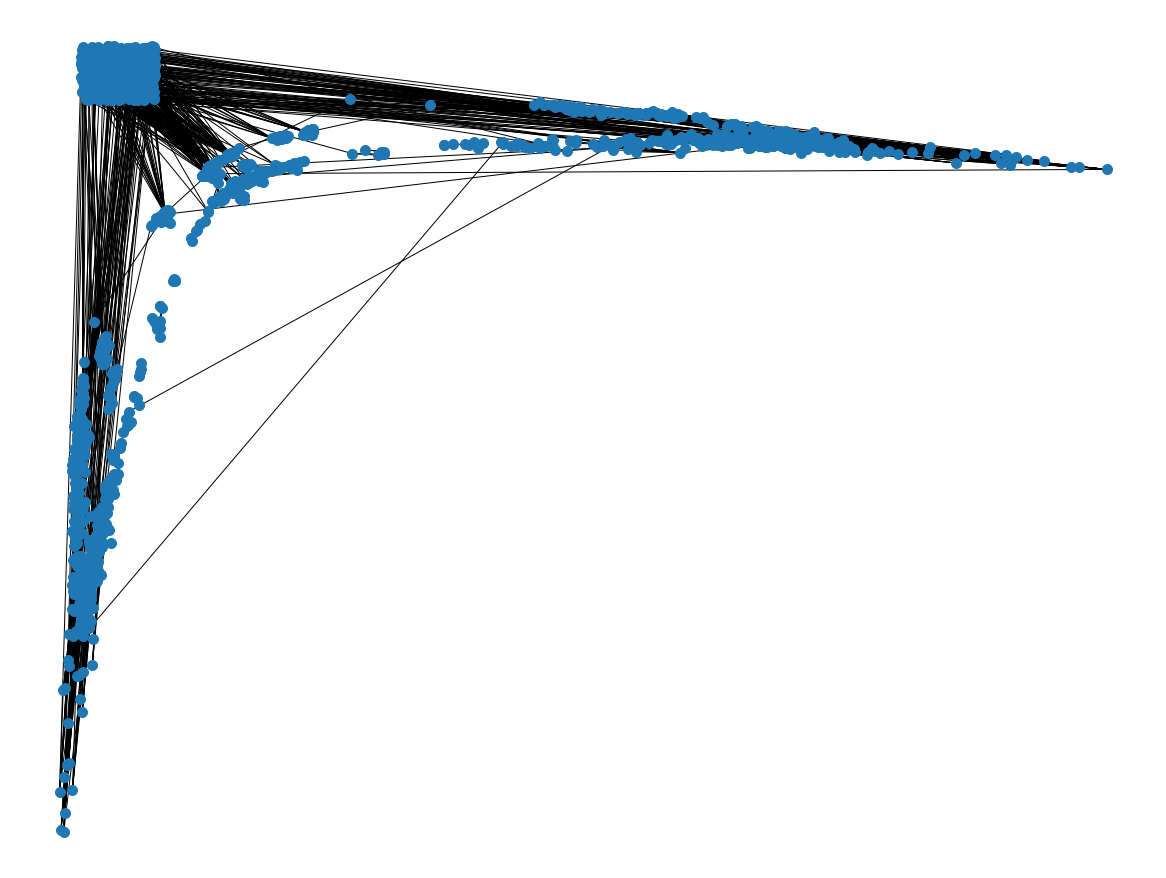

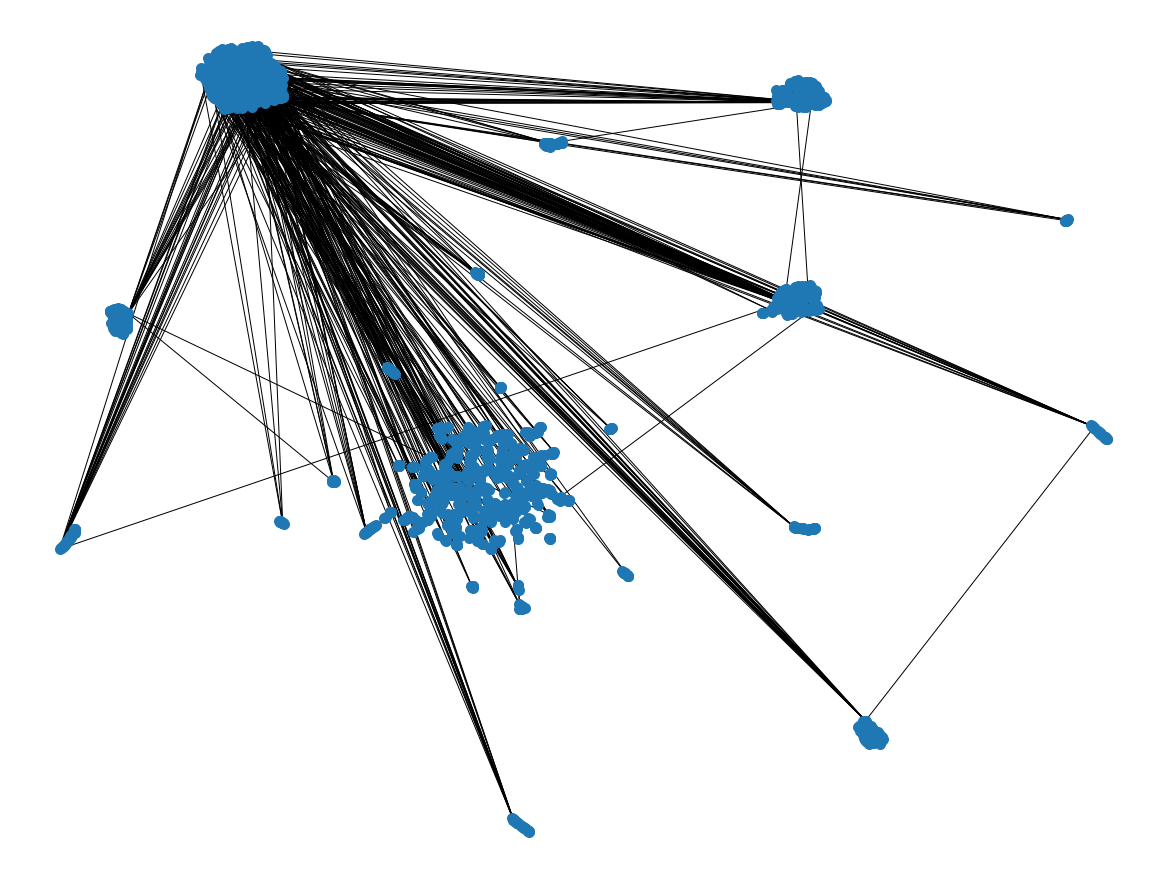

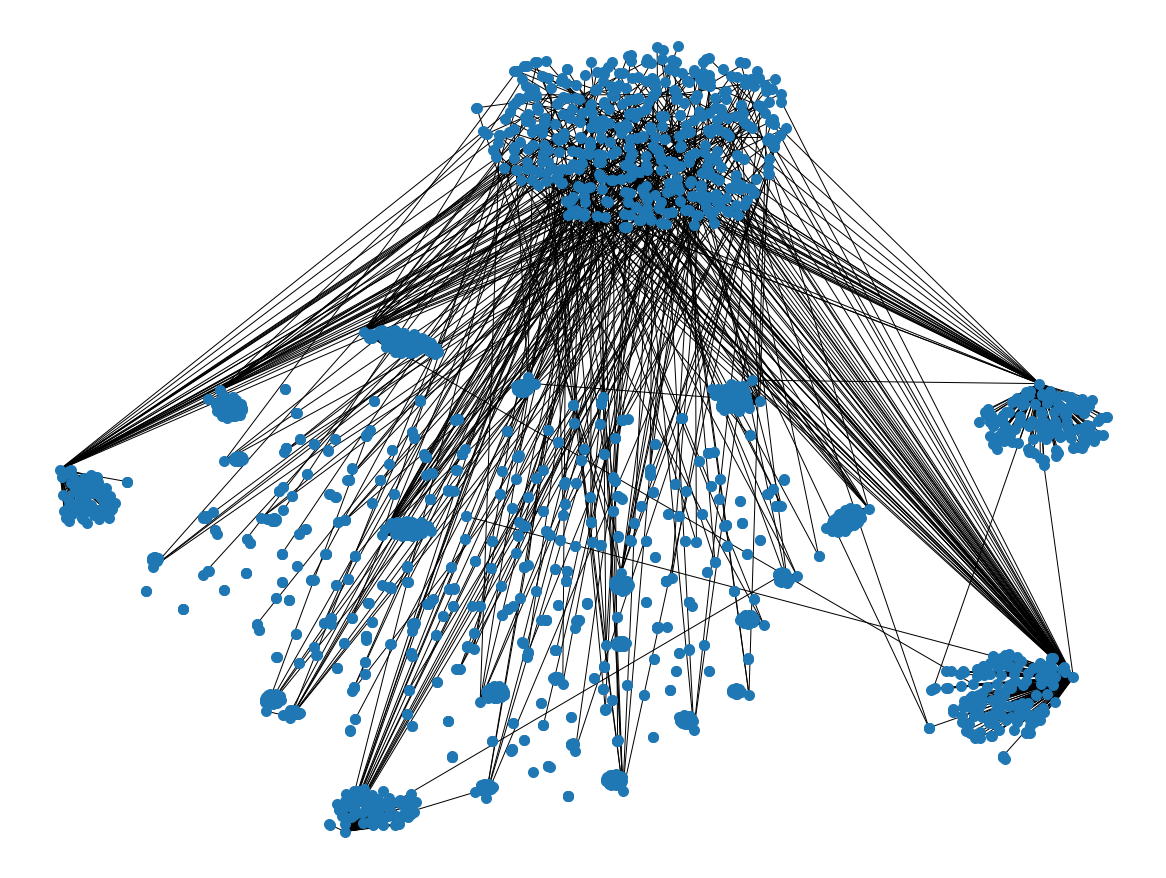

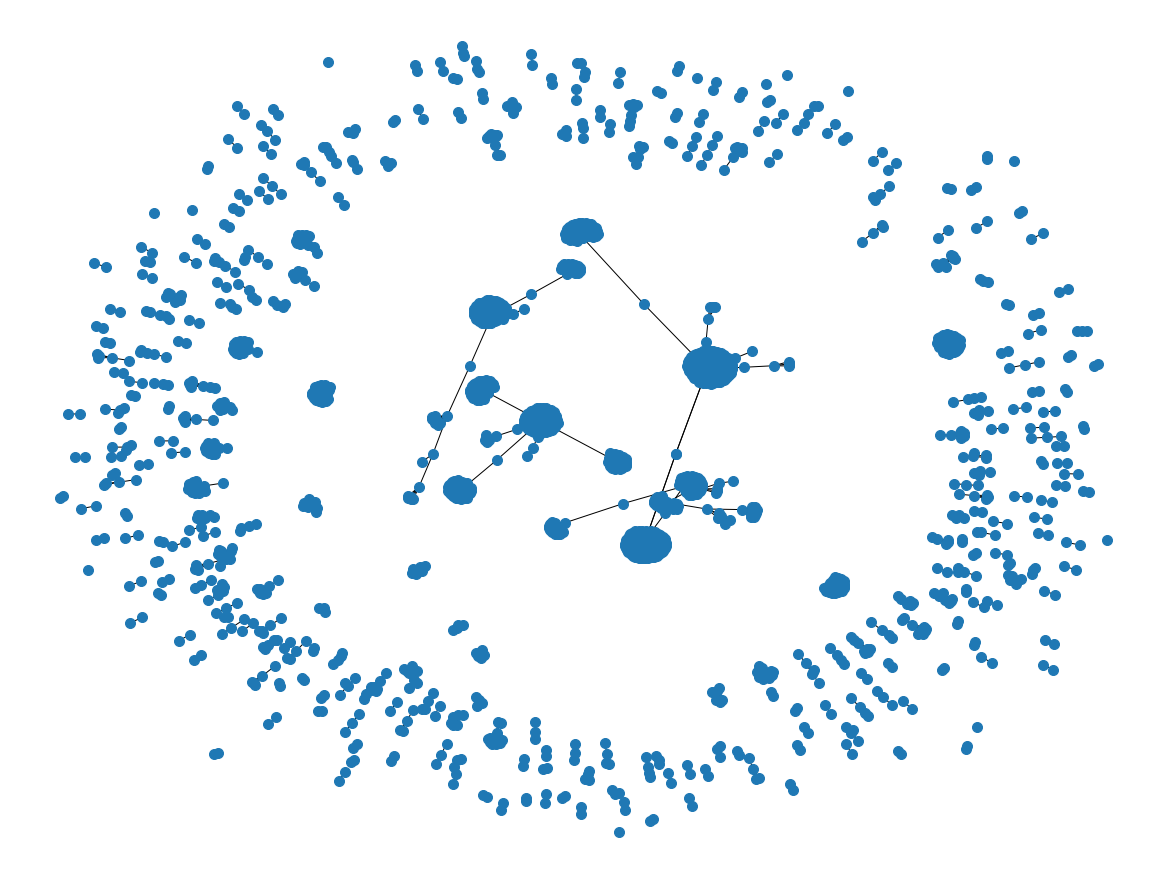

In [8]:
retweet_graph = nx.readwrite.gexf.read_gexf("drive/MyDrive/HKUST/Comp 4641 Project/hashtag_count/retweet_network_v1.1.gexf")
print('number of nodes:', retweet_graph.number_of_nodes())
print('number of edges:', retweet_graph.number_of_edges())
vis1 = visualization(retweet_graph)
vis1.create_embeddings(node2vec(vis1.train_graph, p=5, node_dim=2))
vis1.plot()
print()
vis2 = visualization(retweet_graph)
vis2.create_embeddings(node2vec(vis2.train_graph, p=5))
vis2.plot('UMAP')
print()
vis2.plot('t-SNE')
print()
vis2.plot('FD')
print()

number of nodes: 1553
number of edges: 169432
building a node2vec model...	number of walks: 15530	average walk length: 9.8377	trainig time: 430.7935
0.9184616533119433

building a node2vec model...	number of walks: 15530	average walk length: 9.8030	trainig time: 429.0506
0.9625329969594184





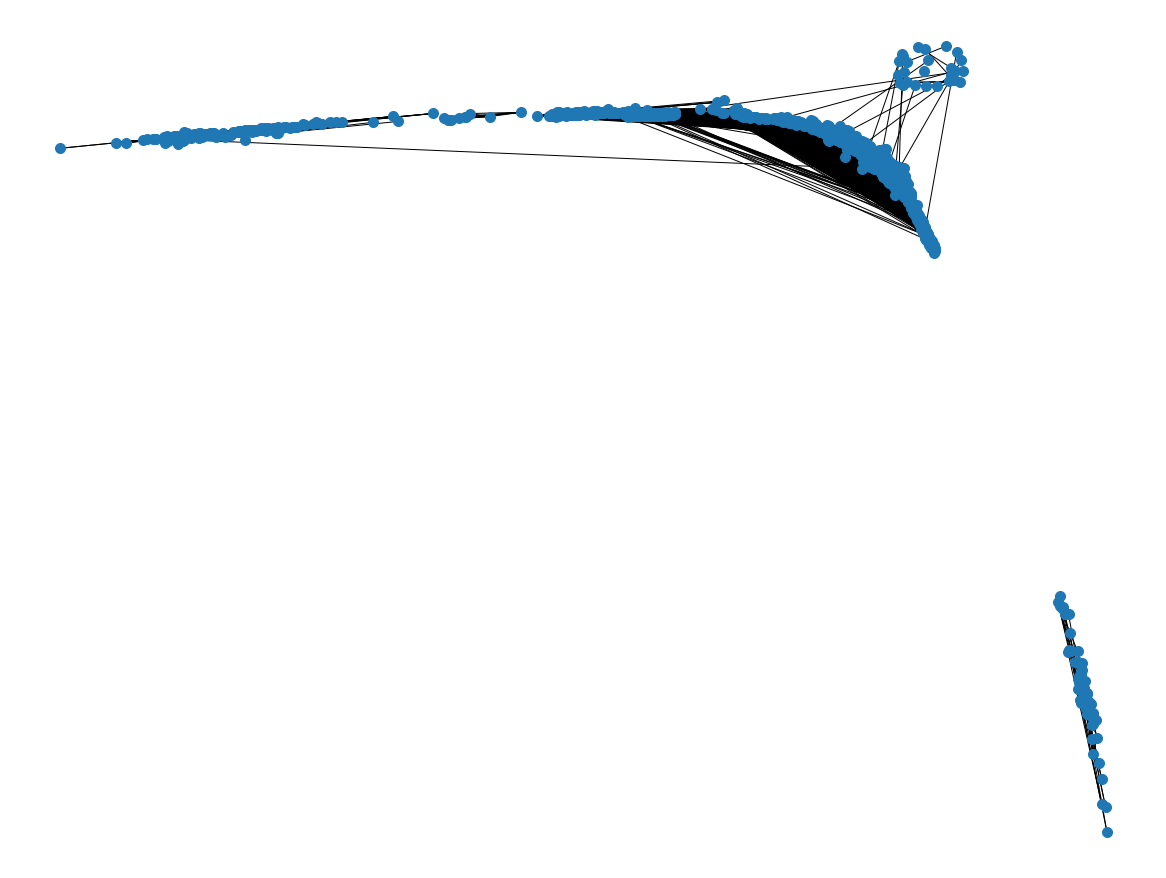

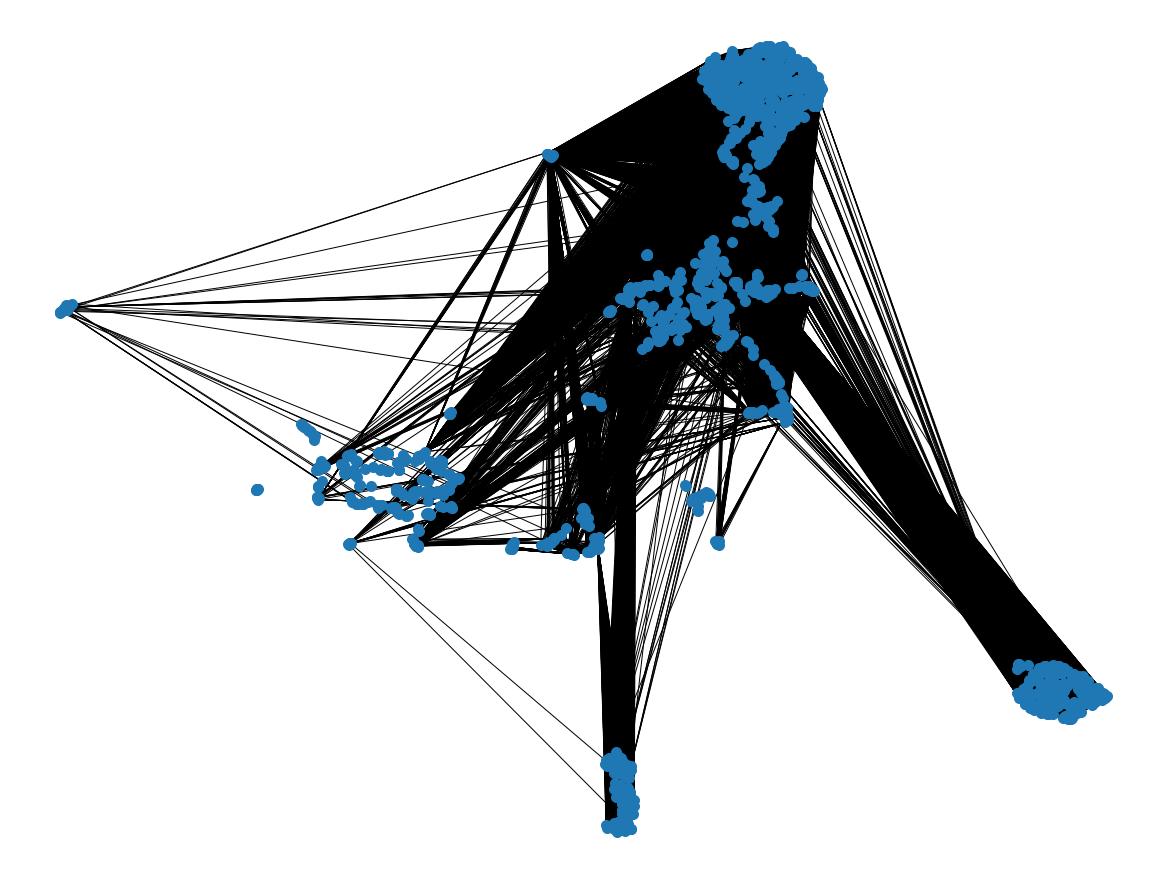

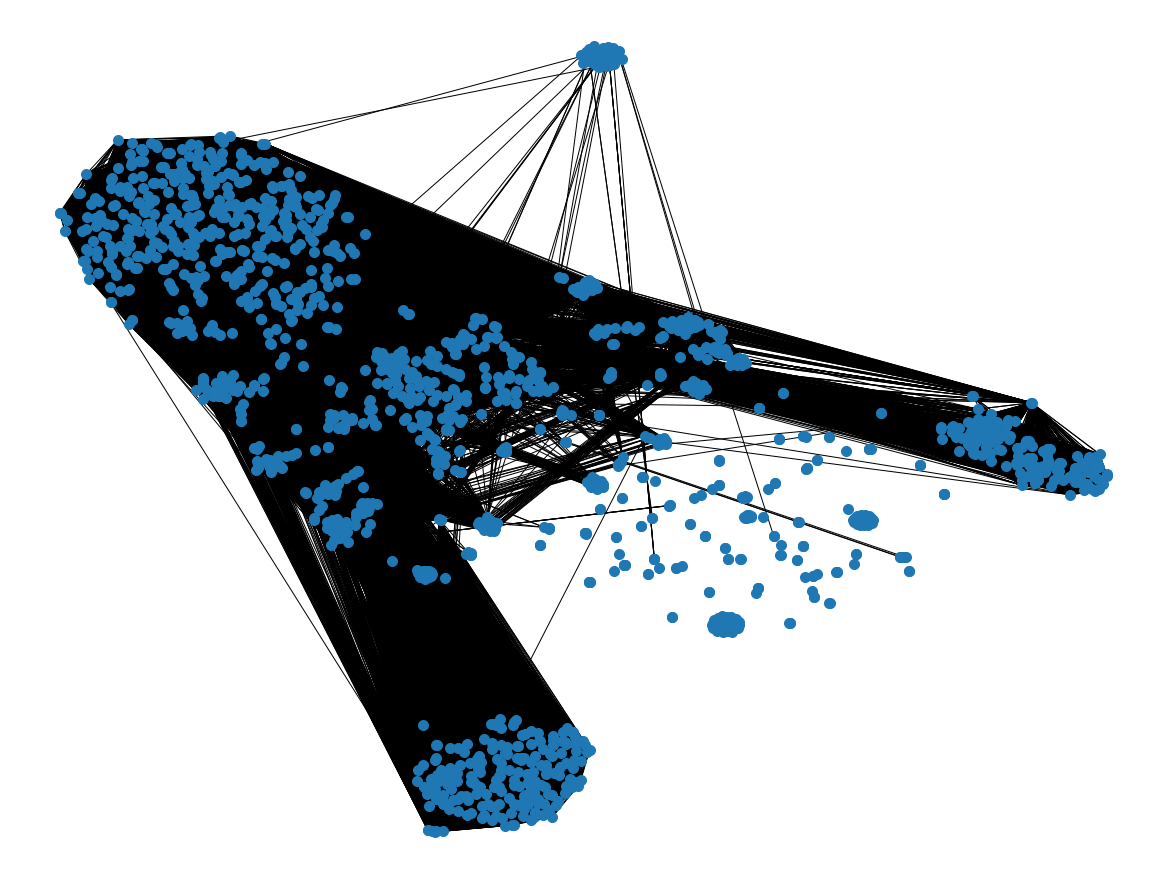

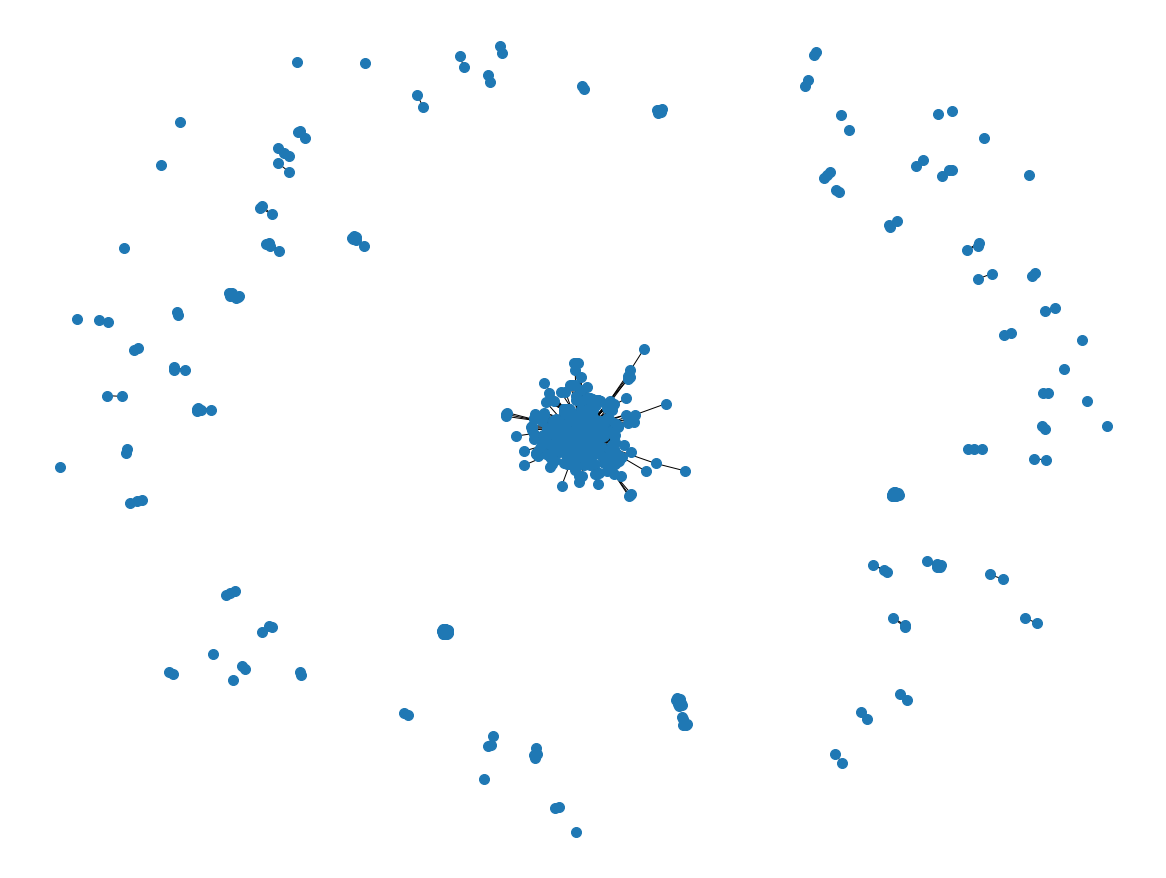

In [9]:
hashtag_graph = nx.readwrite.gexf.read_gexf("drive/MyDrive/HKUST/Comp 4641 Project/hashtag_count/co_hashtag.gexf")
print('number of nodes:', hashtag_graph.number_of_nodes())
print('number of edges:', hashtag_graph.number_of_edges())
for edge in hashtag_graph.edges:
    hashtag_graph[edge[0]][edge[1]]['weight'] = 1
vis1 = visualization(hashtag_graph)
vis1.create_embeddings(node2vec(vis1.train_graph, p=5, node_dim=2))
vis1.plot()
print()
vis2 = visualization(hashtag_graph)
vis2.create_embeddings(node2vec(vis2.train_graph, p=5))
vis2.plot('UMAP')
print()
vis2.plot('t-SNE')
print()
vis2.plot('FD')
print()

number of nodes: 933
number of edges: 29194
building a node2vec model...	number of walks: 9330	average walk length: 9.6527	trainig time: 26.2641
0.9453994348264063

building a node2vec model...	number of walks: 9330	average walk length: 9.6141	trainig time: 26.5273
0.9961330474846004





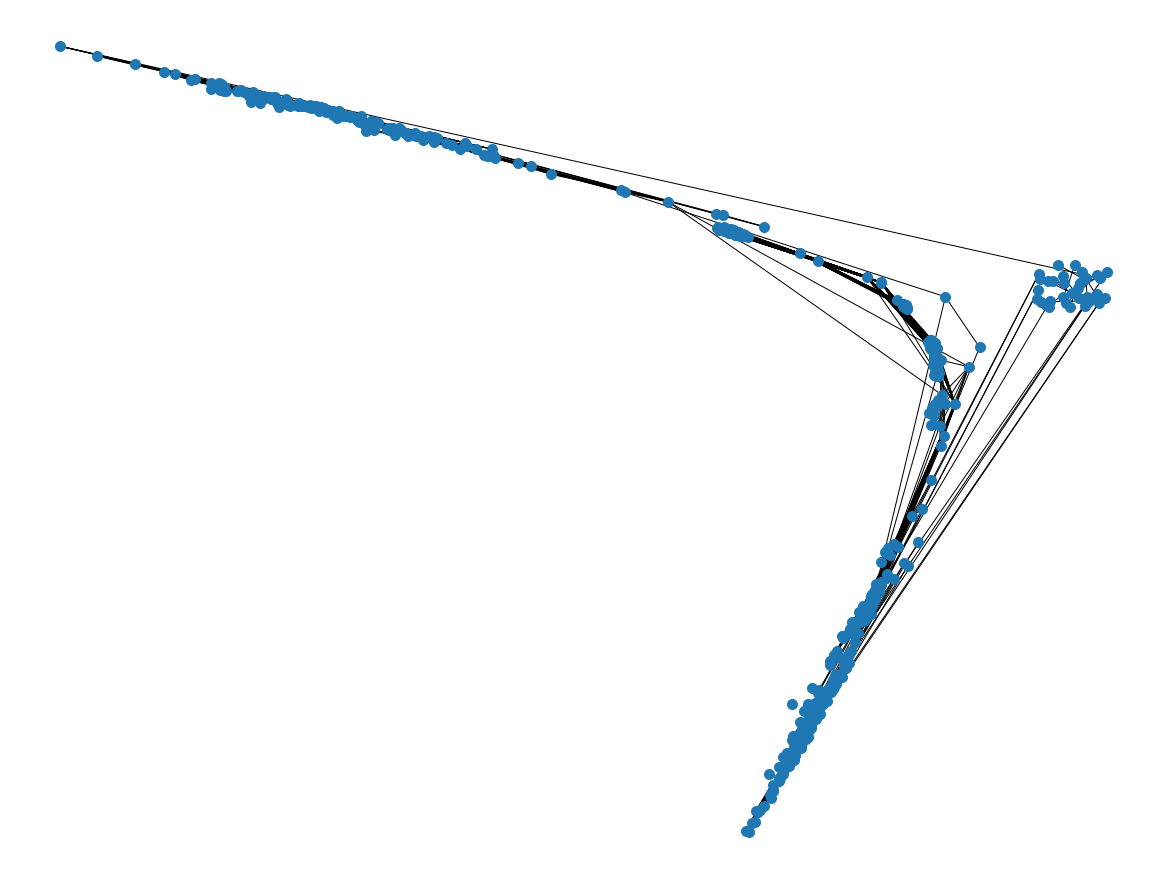

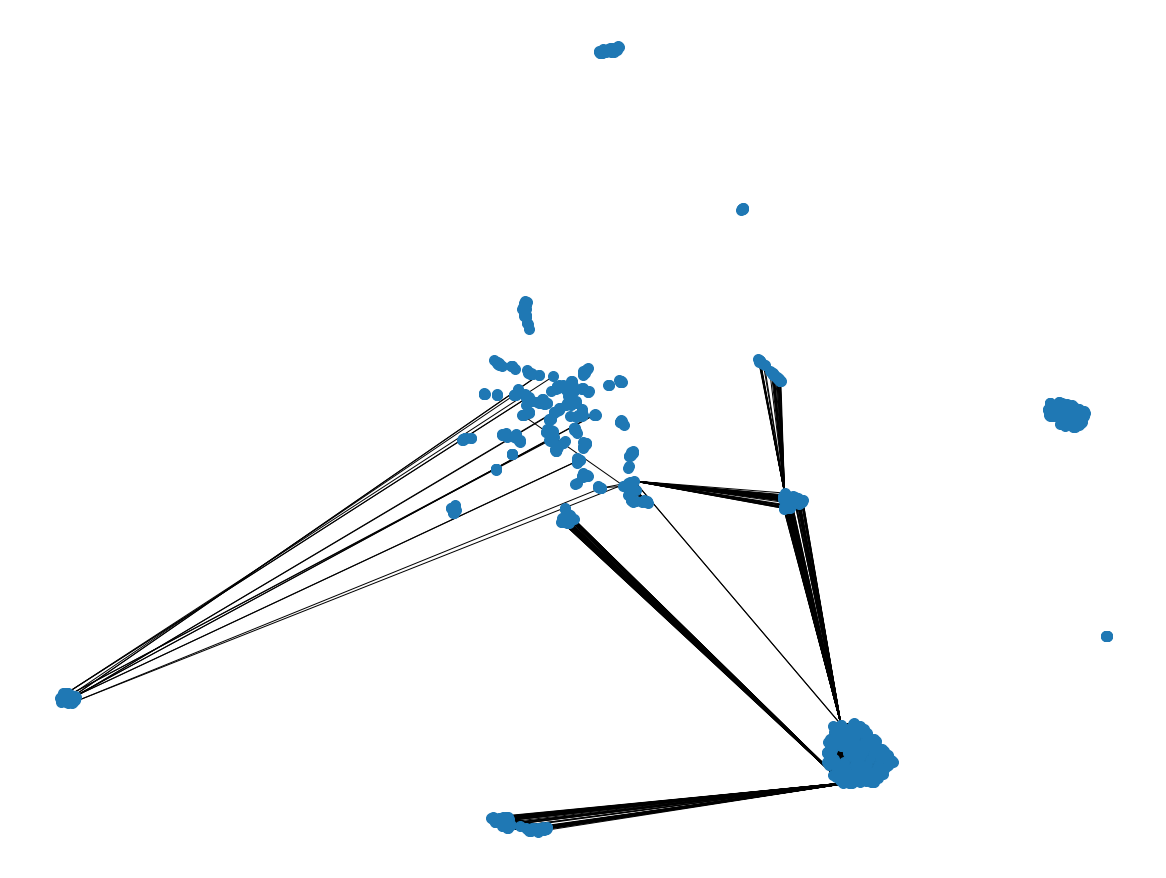

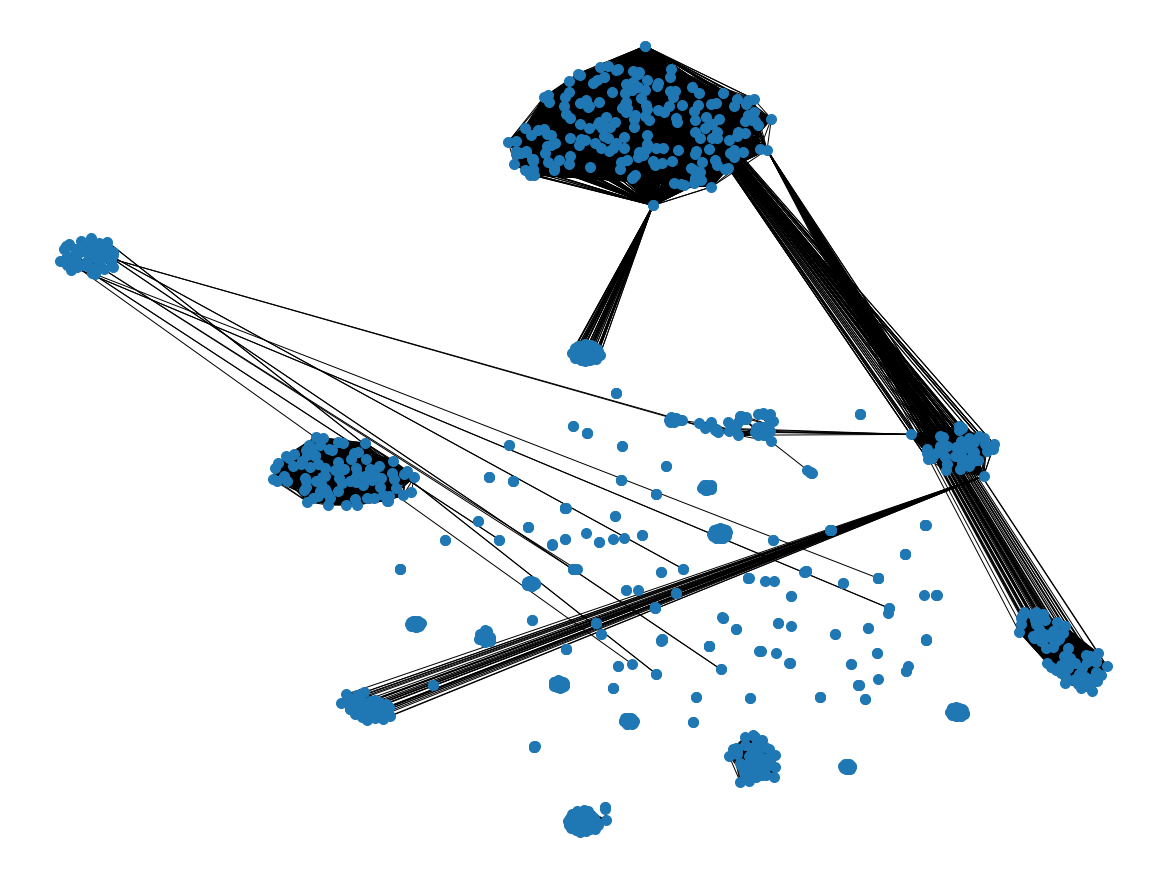

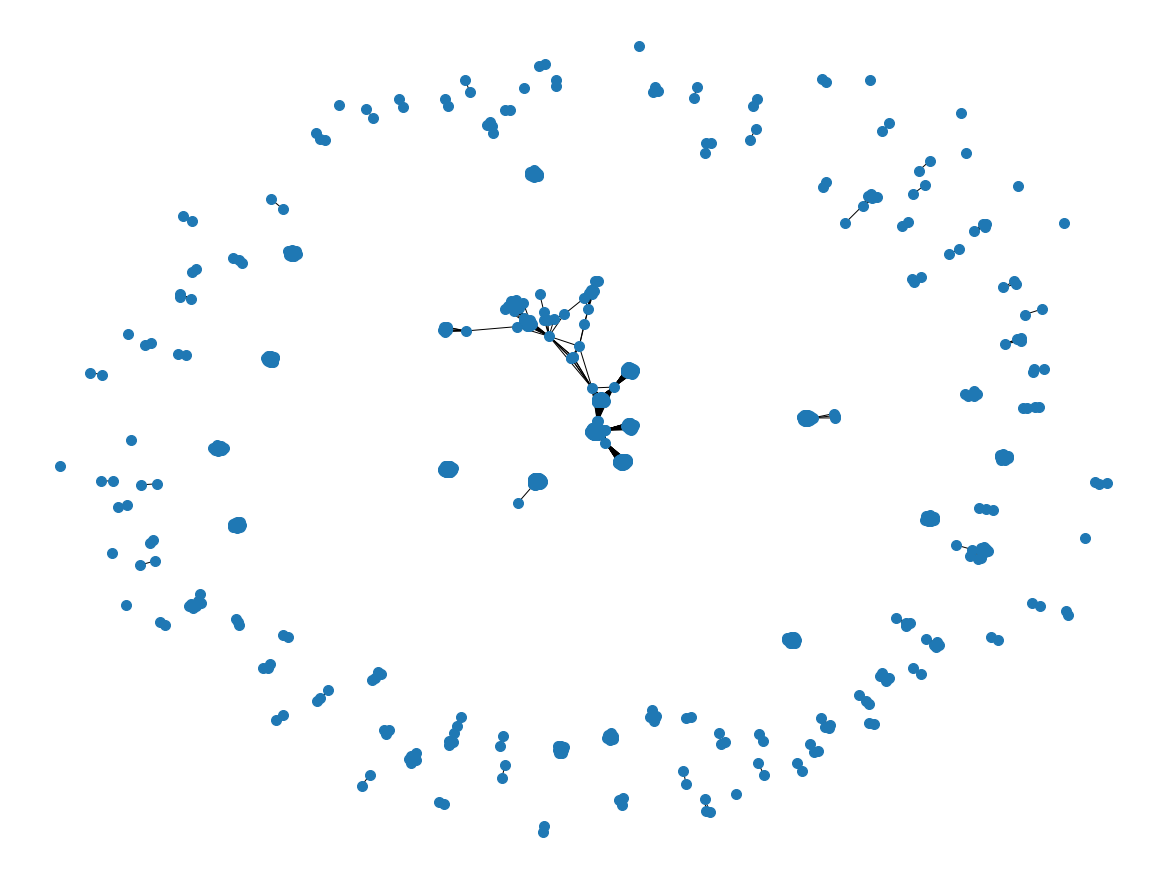

In [10]:
mentions_graph = nx.readwrite.gexf.read_gexf("drive/MyDrive/HKUST/Comp 4641 Project/hashtag_count/co_mentions.gexf")
print('number of nodes:', mentions_graph.number_of_nodes())
print('number of edges:', mentions_graph.number_of_edges())
for edge in mentions_graph.edges:
    mentions_graph[edge[0]][edge[1]]['weight'] = 1
vis1 = visualization(mentions_graph)
vis1.create_embeddings(node2vec(vis1.train_graph, p=5, node_dim=2))
vis1.plot()
print()
vis2 = visualization(mentions_graph)
vis2.create_embeddings(node2vec(vis2.train_graph, p=5))
vis2.plot('UMAP')
print()
vis2.plot('t-SNE')
print()
vis2.plot('FD')
print()

In [11]:
def combine_graphs(graph_list):
    graph = nx.Graph()
    for g in graph_list:
        for edge in g.edges():
            if (edge[0], edge[1]) in graph:
                graph[edge[0]][edge[1]]['weight'] += g[edge[0]][edge[1]]['weight']
            else:
                graph.add_edge(edge[0], edge[1])
                graph[edge[0]][edge[1]]['weight'] = g[edge[0]][edge[1]]['weight']
    return graph

number of nodes: 3466
number of edges: 171076
building a node2vec model...	number of walks: 34660	average walk length: 8.6887	trainig time: 437.4268
0.9196912885295188

building a node2vec model...	number of walks: 34660	average walk length: 8.6757	trainig time: 430.5219
0.9812560384840752





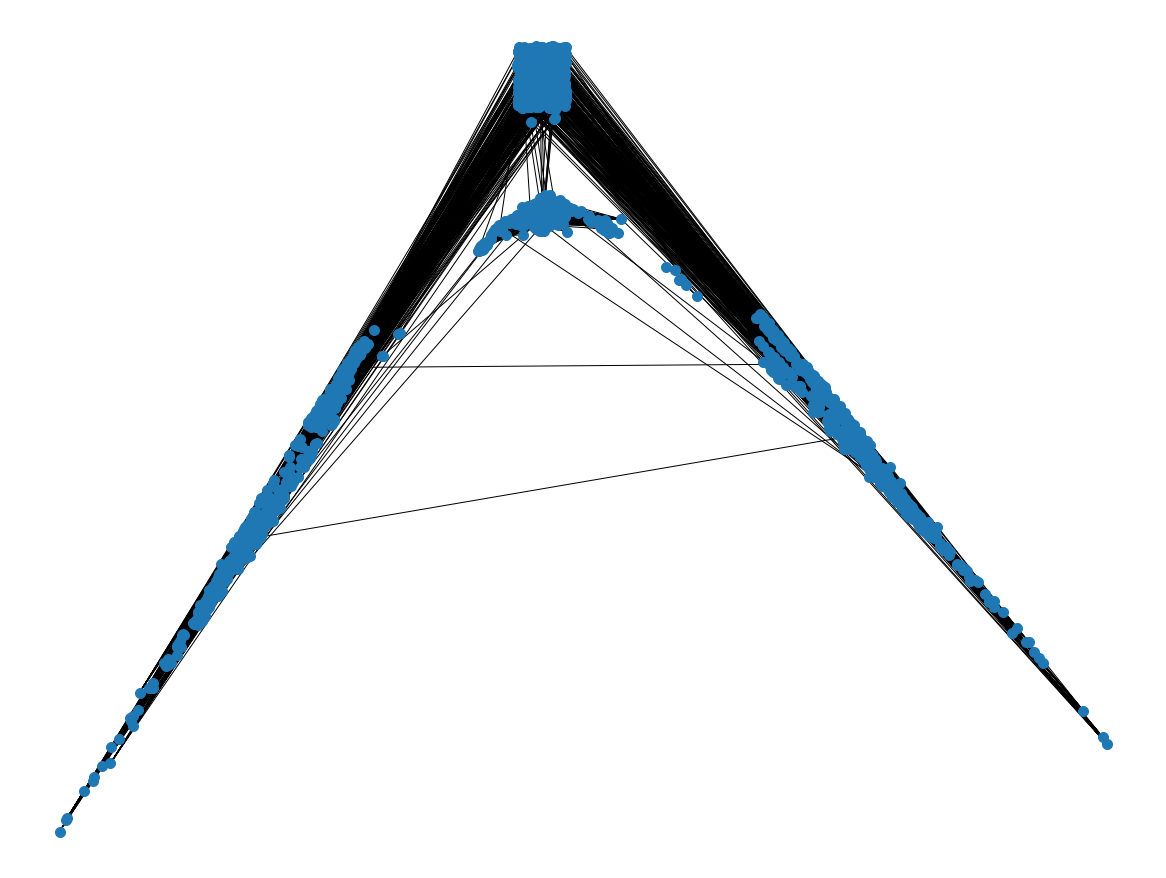

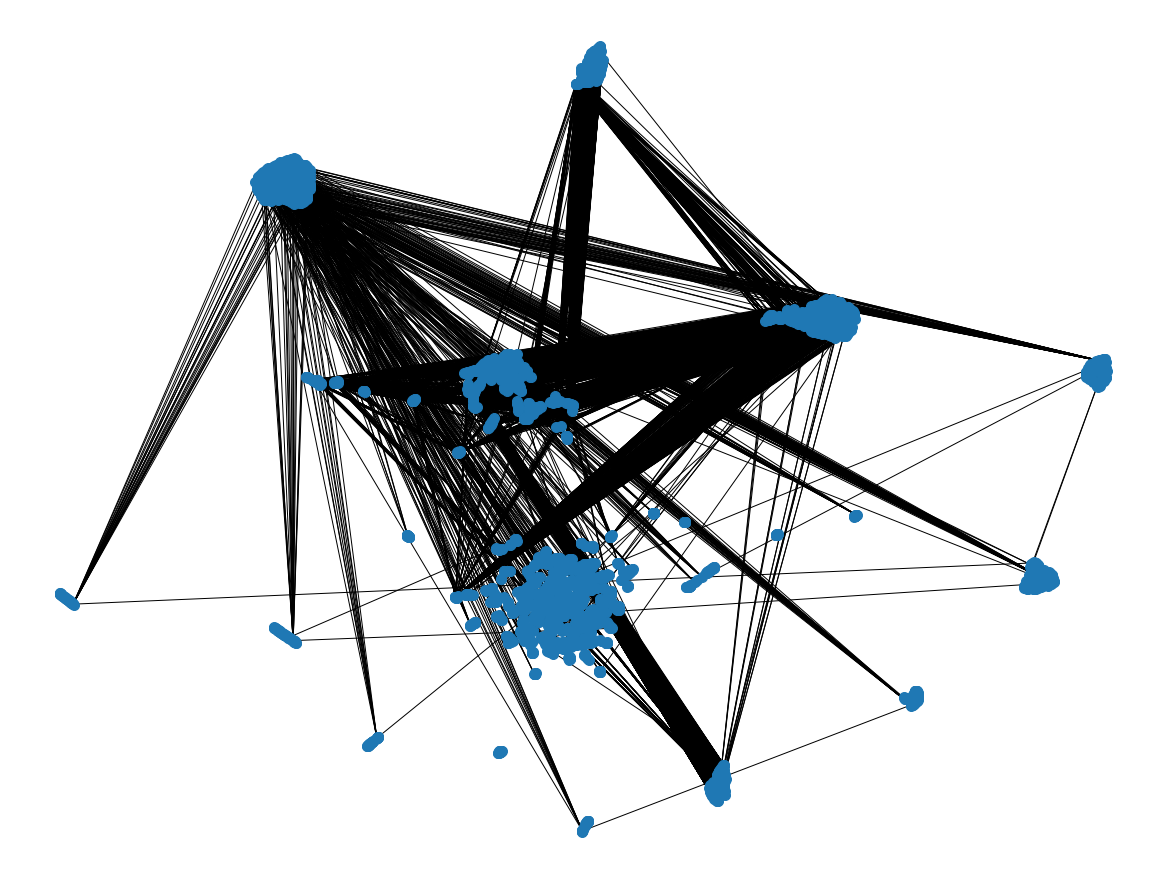

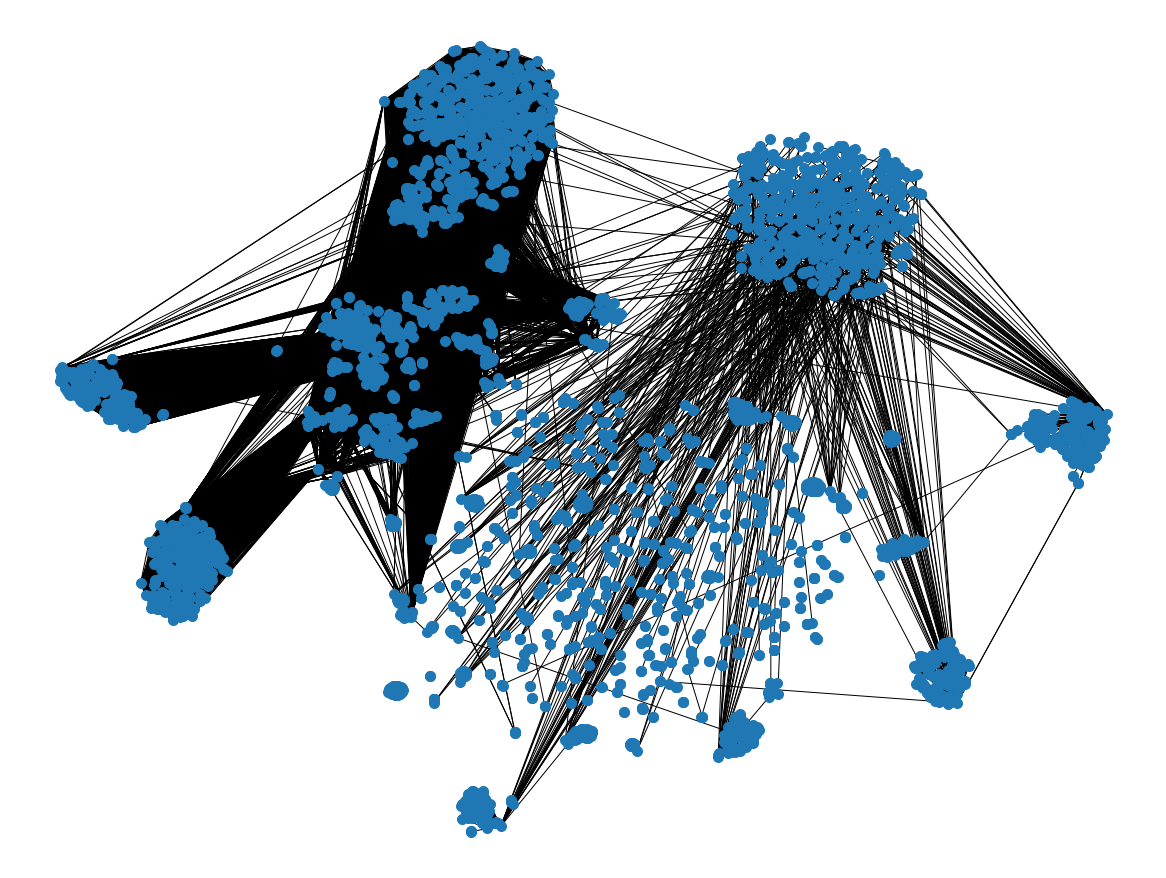

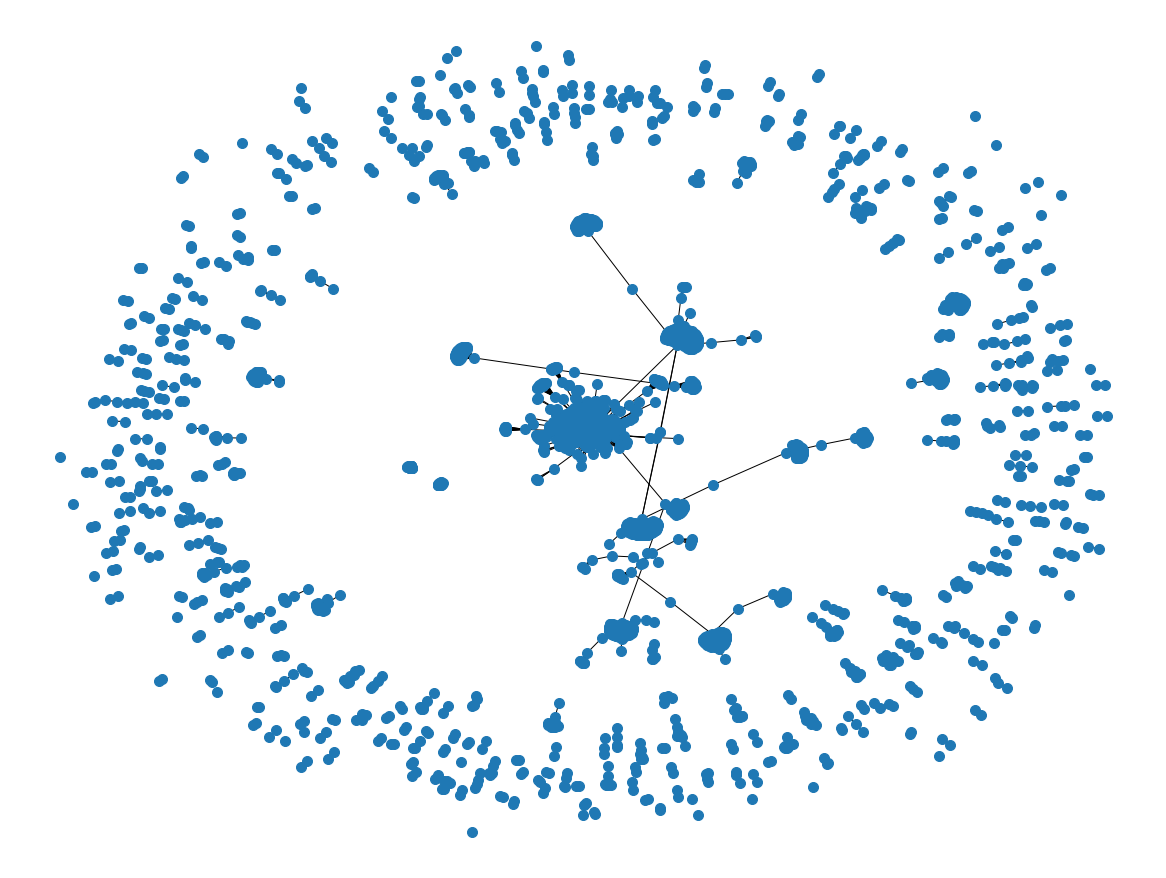

In [12]:
rh_graph = combine_graphs([retweet_graph, hashtag_graph])
print('number of nodes:', rh_graph.number_of_nodes())
print('number of edges:', rh_graph.number_of_edges())
vis1 = visualization(rh_graph)
vis1.create_embeddings(node2vec(vis1.train_graph, p=5, node_dim=2))
vis1.plot()
print()
vis2 = visualization(rh_graph)
vis2.create_embeddings(node2vec(vis2.train_graph, p=5))
vis2.plot('UMAP')
print()
vis2.plot('t-SNE')
print()
vis2.plot('FD')
print()

number of nodes: 2537
number of edges: 30839
building a node2vec model...	number of walks: 25370	average walk length: 8.5704	trainig time: 31.0986
0.9309560816266474

building a node2vec model...	number of walks: 25370	average walk length: 8.5562	trainig time: 30.7119
0.9605571929149832





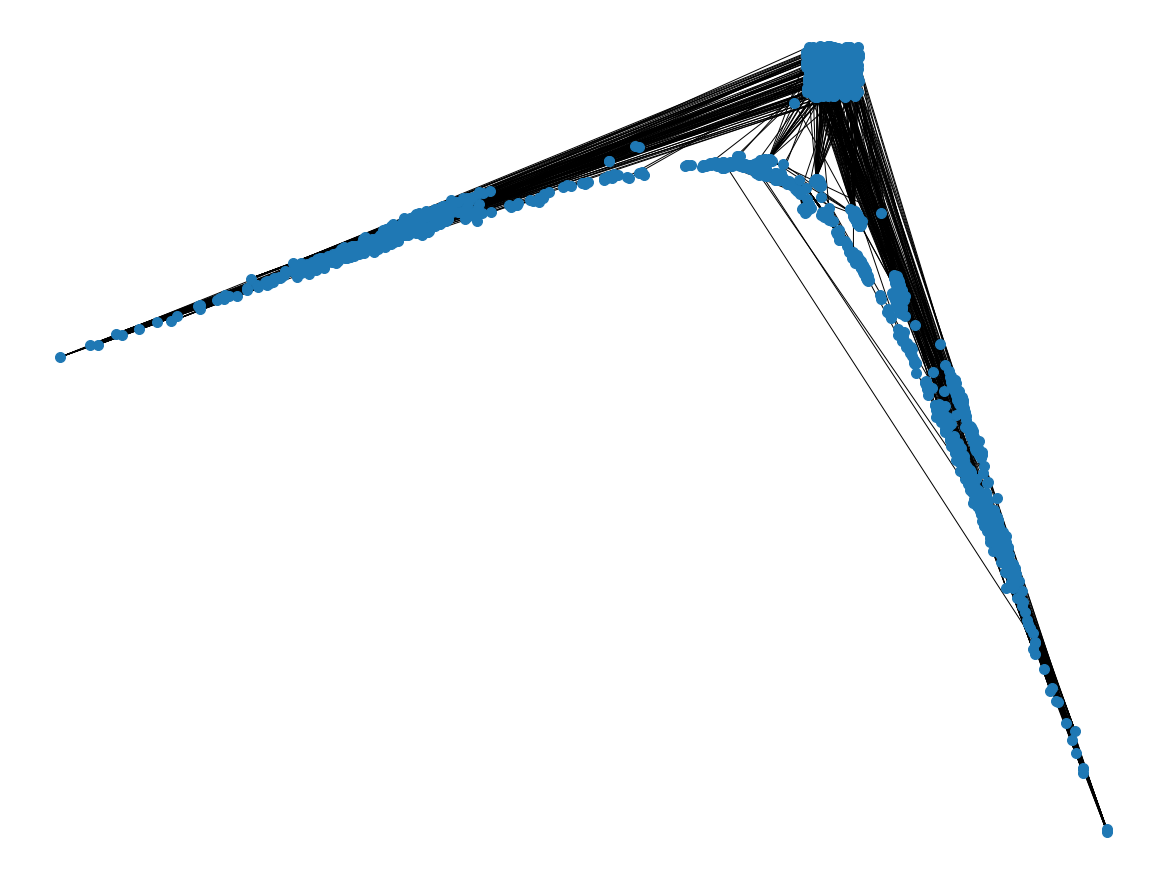

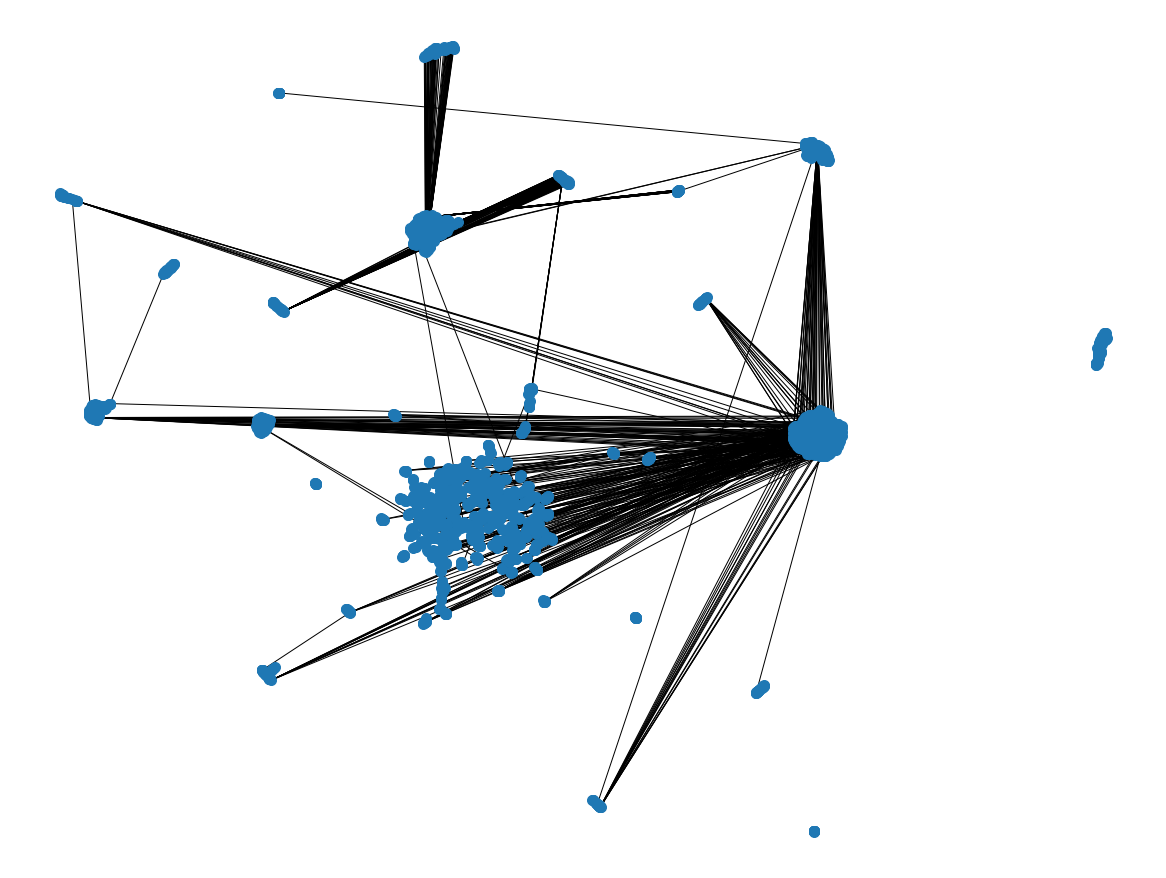

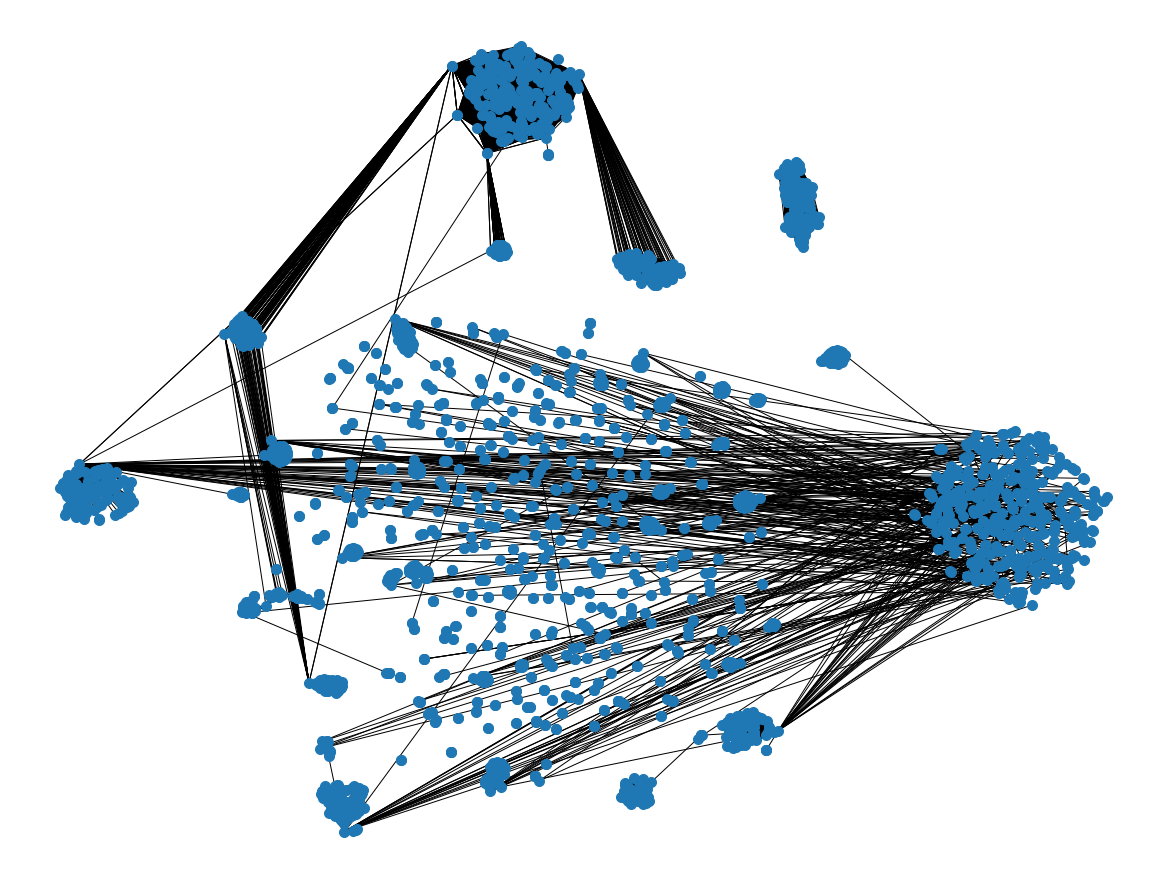

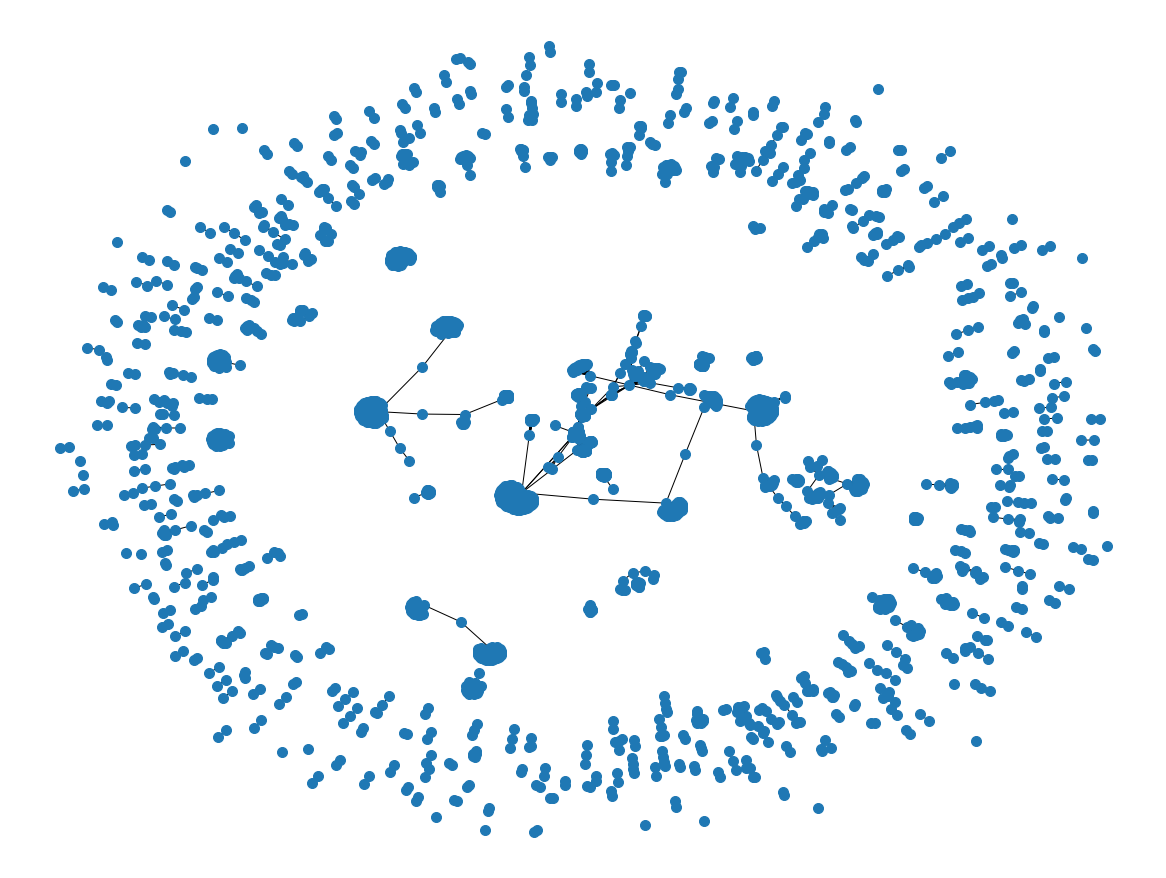

In [13]:
rm_graph = combine_graphs([retweet_graph, mentions_graph])
print('number of nodes:', rm_graph.number_of_nodes())
print('number of edges:', rm_graph.number_of_edges())
vis1 = visualization(rm_graph)
vis1.create_embeddings(node2vec(vis1.train_graph, p=5, node_dim=2))
vis1.plot()
print()
vis2 = visualization(rm_graph)
vis2.create_embeddings(node2vec(vis2.train_graph, p=5))
vis2.plot('UMAP')
print()
vis2.plot('t-SNE')
print()
vis2.plot('FD')
print()

number of nodes: 2298
number of edges: 194677
building a node2vec model...	number of walks: 25370	average walk length: 8.5987	trainig time: 30.1071
0.9316609685481662

building a node2vec model...	number of walks: 22980	average walk length: 9.6632	trainig time: 454.9205
0.9860607447467049





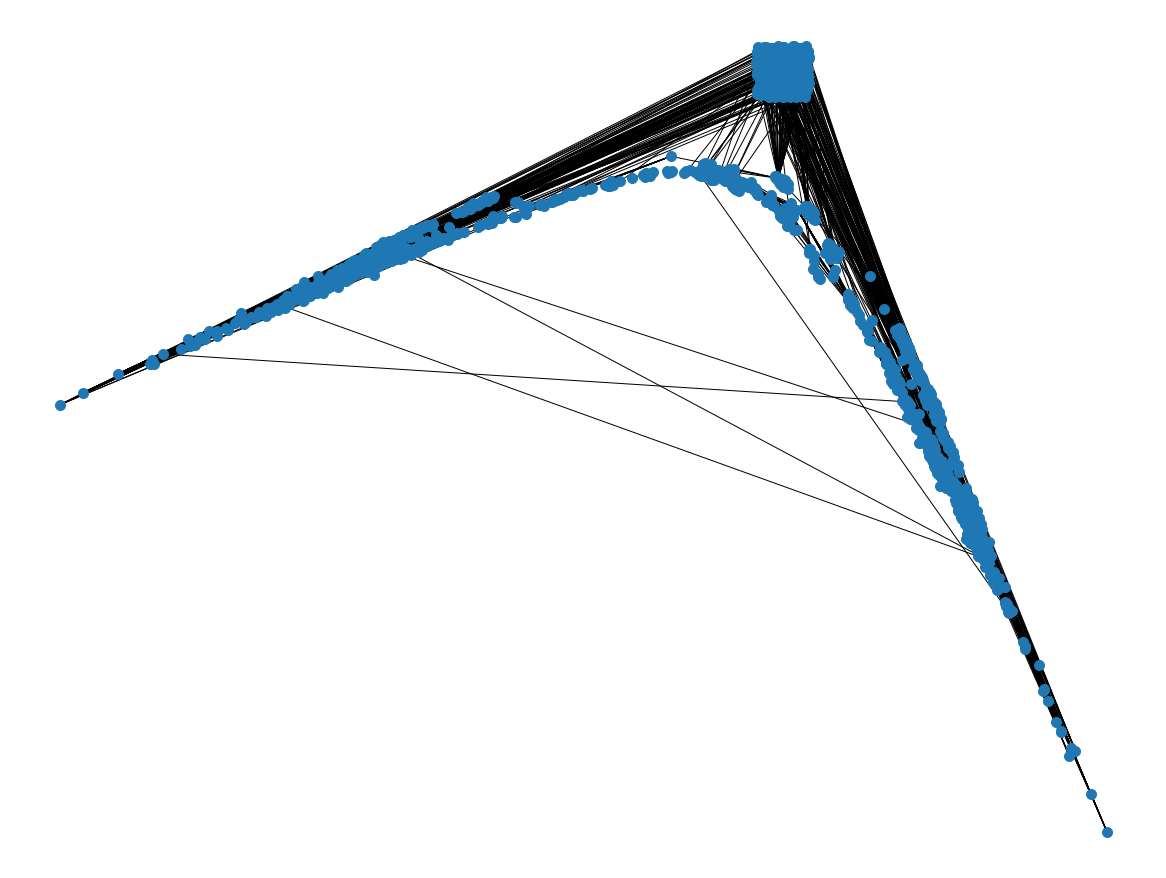

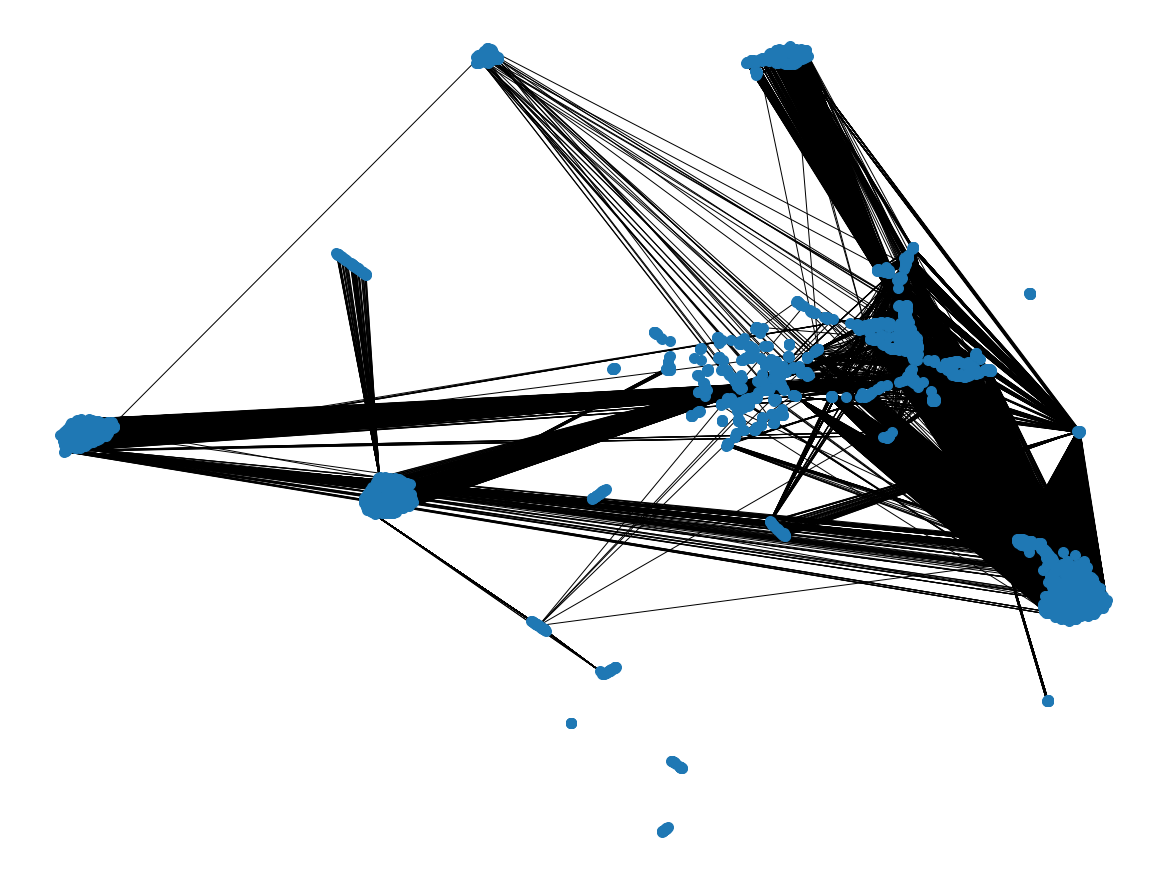

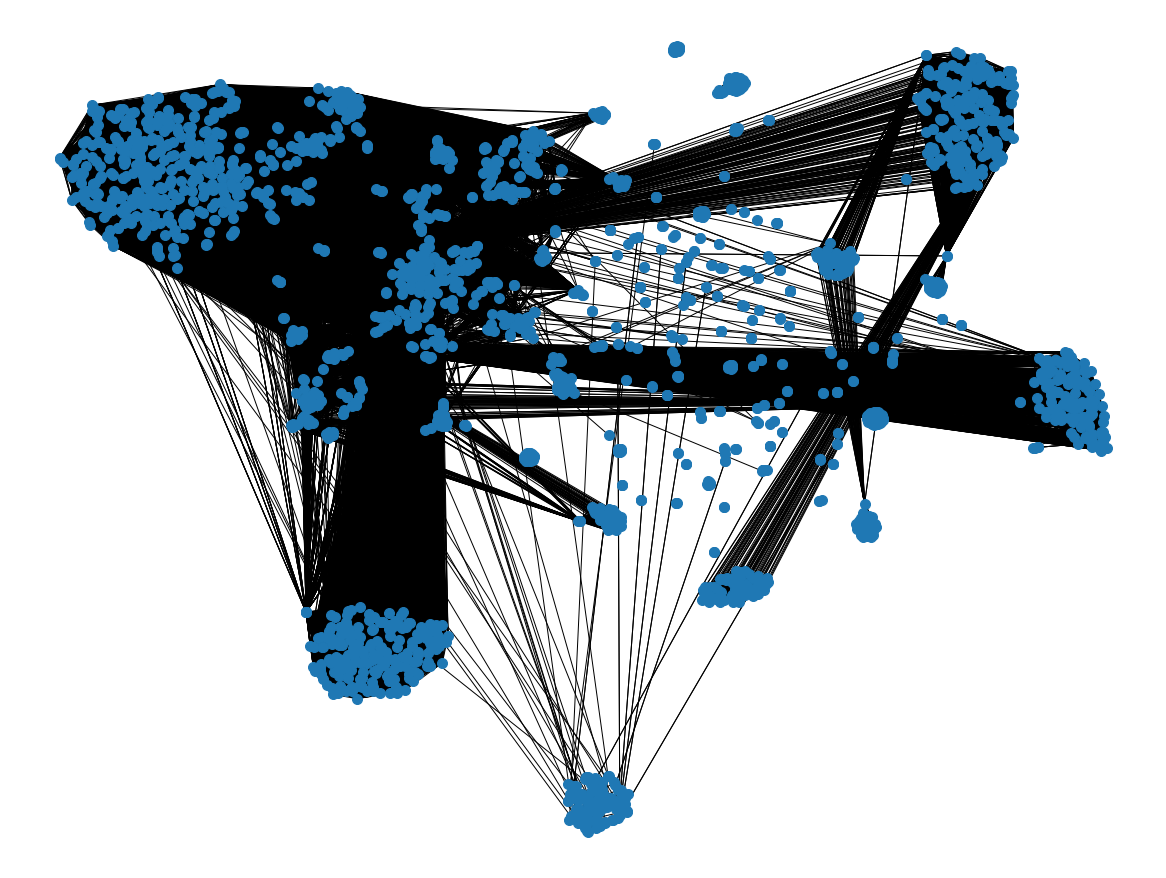

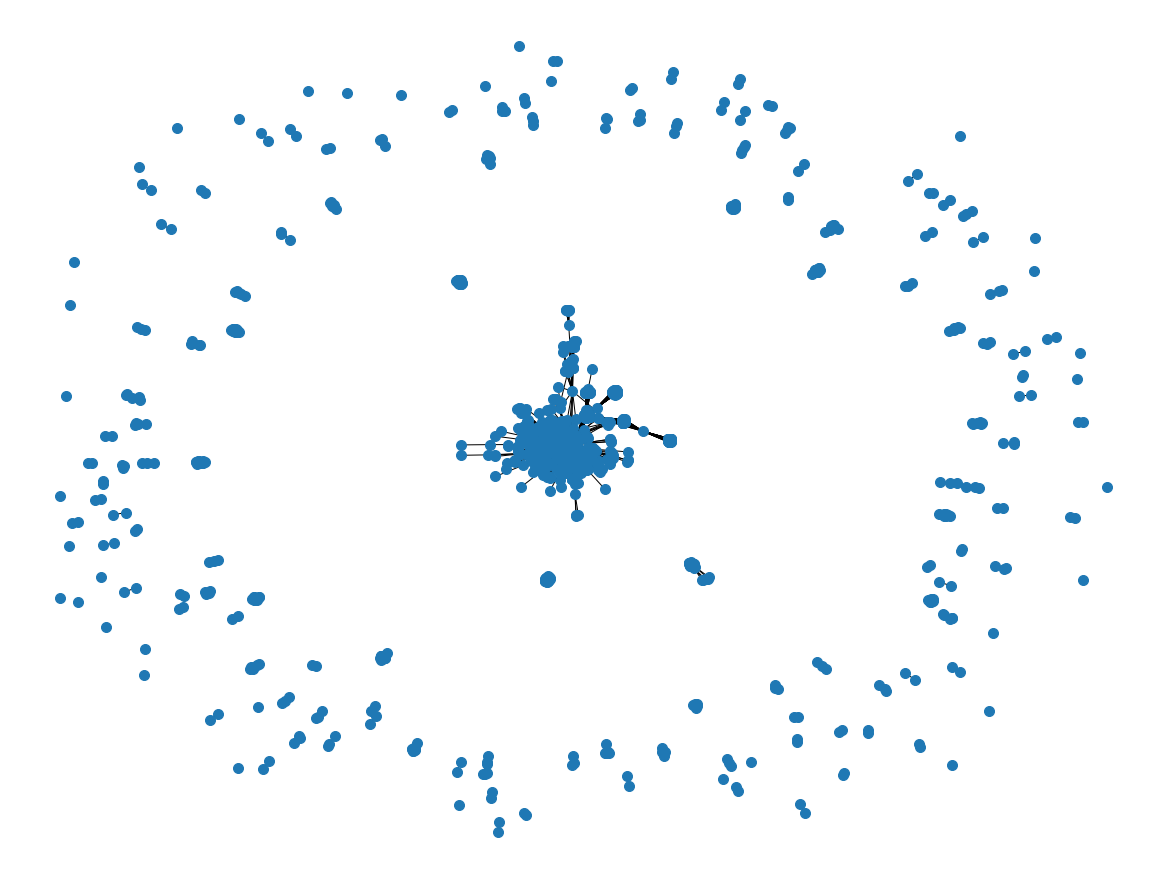

In [14]:
hm_graph = combine_graphs([hashtag_graph, mentions_graph])
print('number of nodes:', hm_graph.number_of_nodes())
print('number of edges:', hm_graph.number_of_edges())
vis1 = visualization(rm_graph)
vis1.create_embeddings(node2vec(vis1.train_graph, p=5, node_dim=2))
vis1.plot()
print()
vis2 = visualization(hm_graph)
vis2.create_embeddings(node2vec(vis2.train_graph, p=5))
vis2.plot('UMAP')
print()
vis2.plot('t-SNE')
print()
vis2.plot('FD')
print()

number of nodes: 3880
number of edges: 196321
building a node2vec model...	number of walks: 25370	average walk length: 8.6023	trainig time: 31.1481
0.9305469105060569

building a node2vec model...	number of walks: 38800	average walk length: 9.0536	trainig time: 455.5767
0.9864626229385155





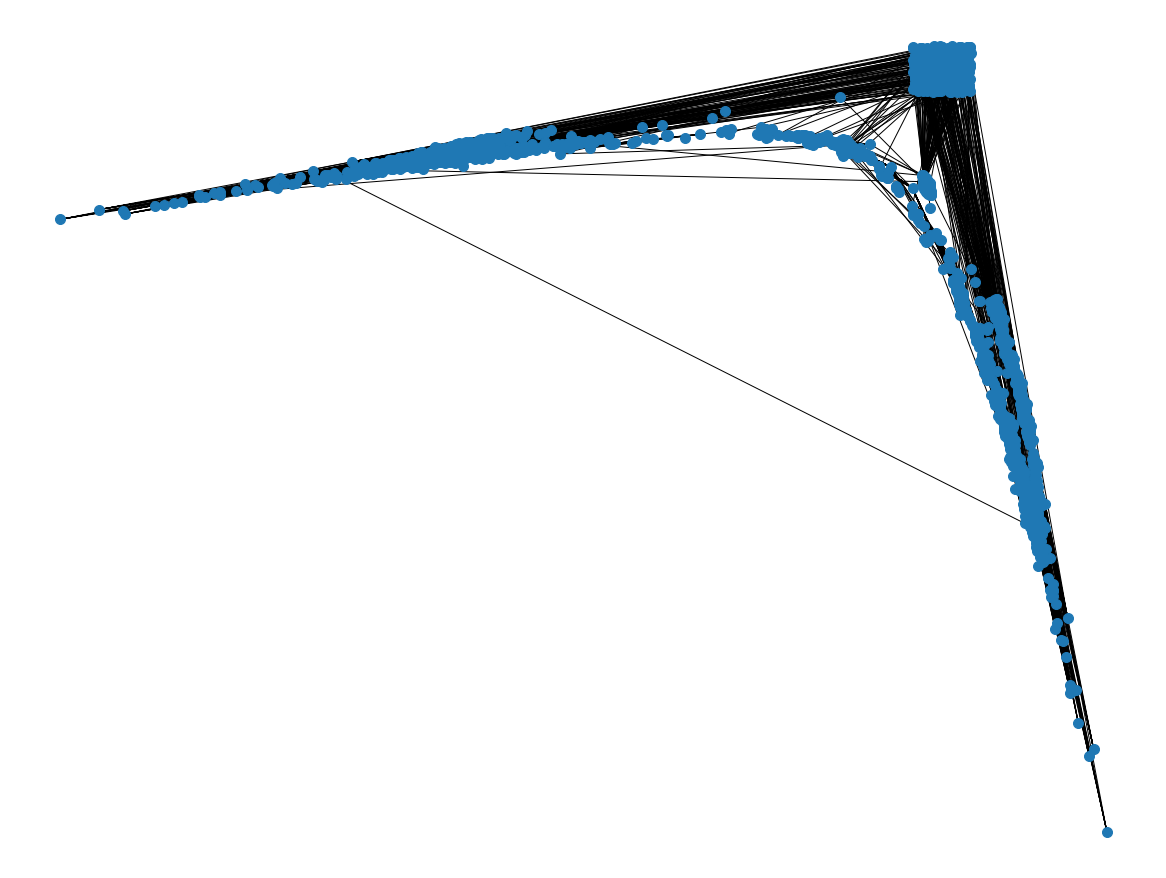

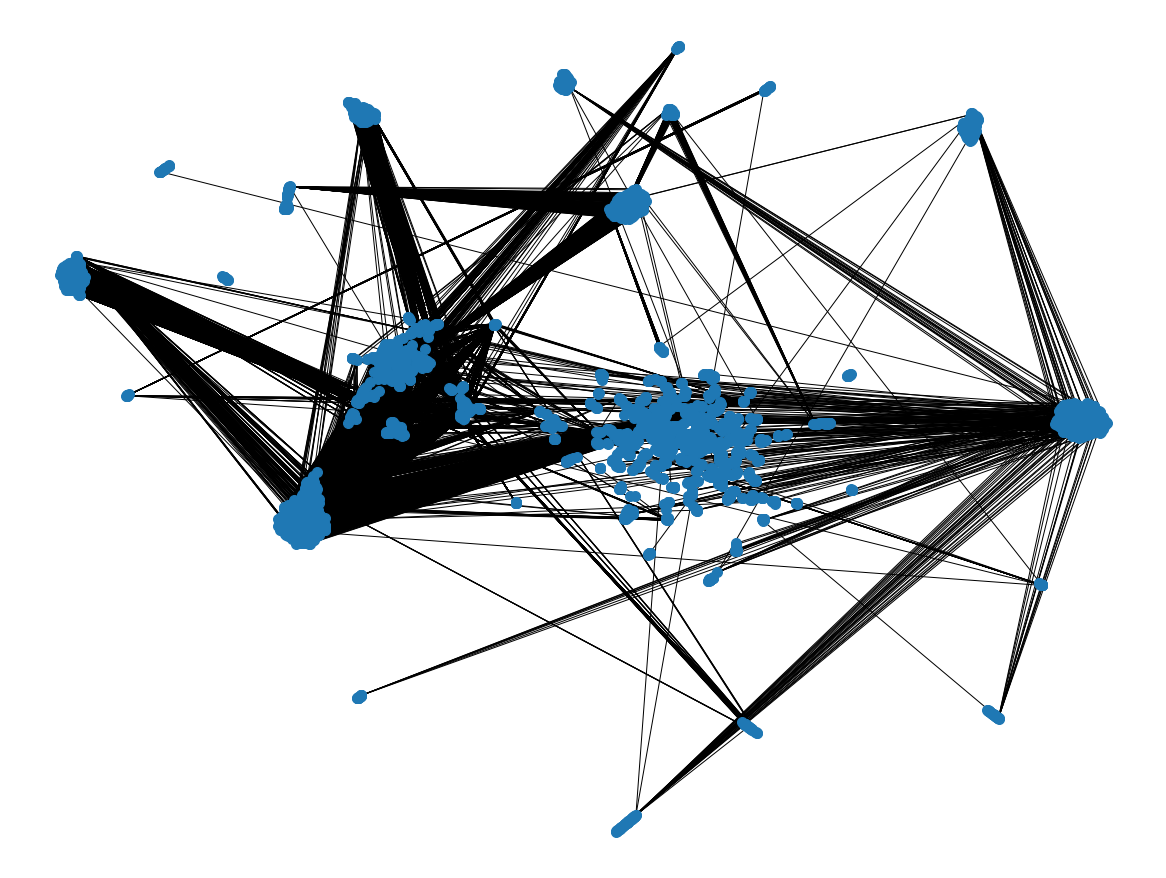

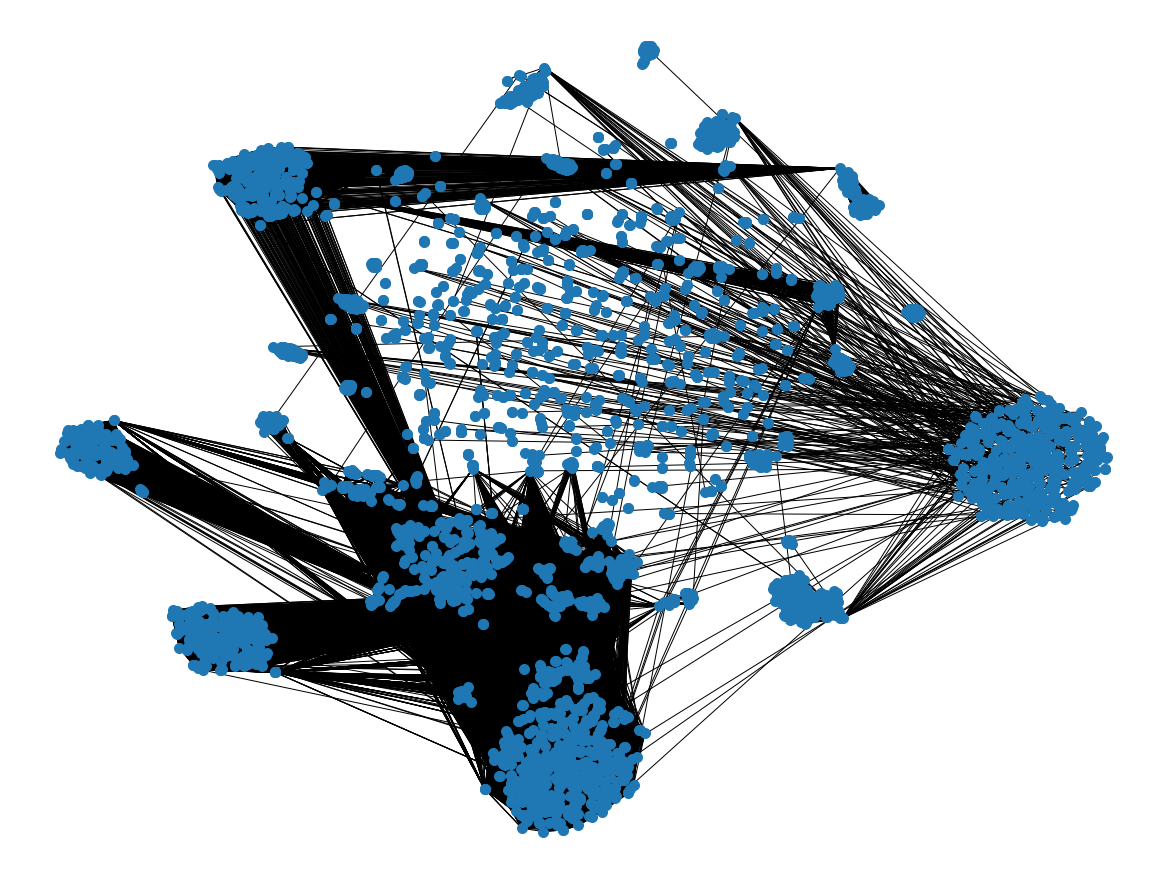

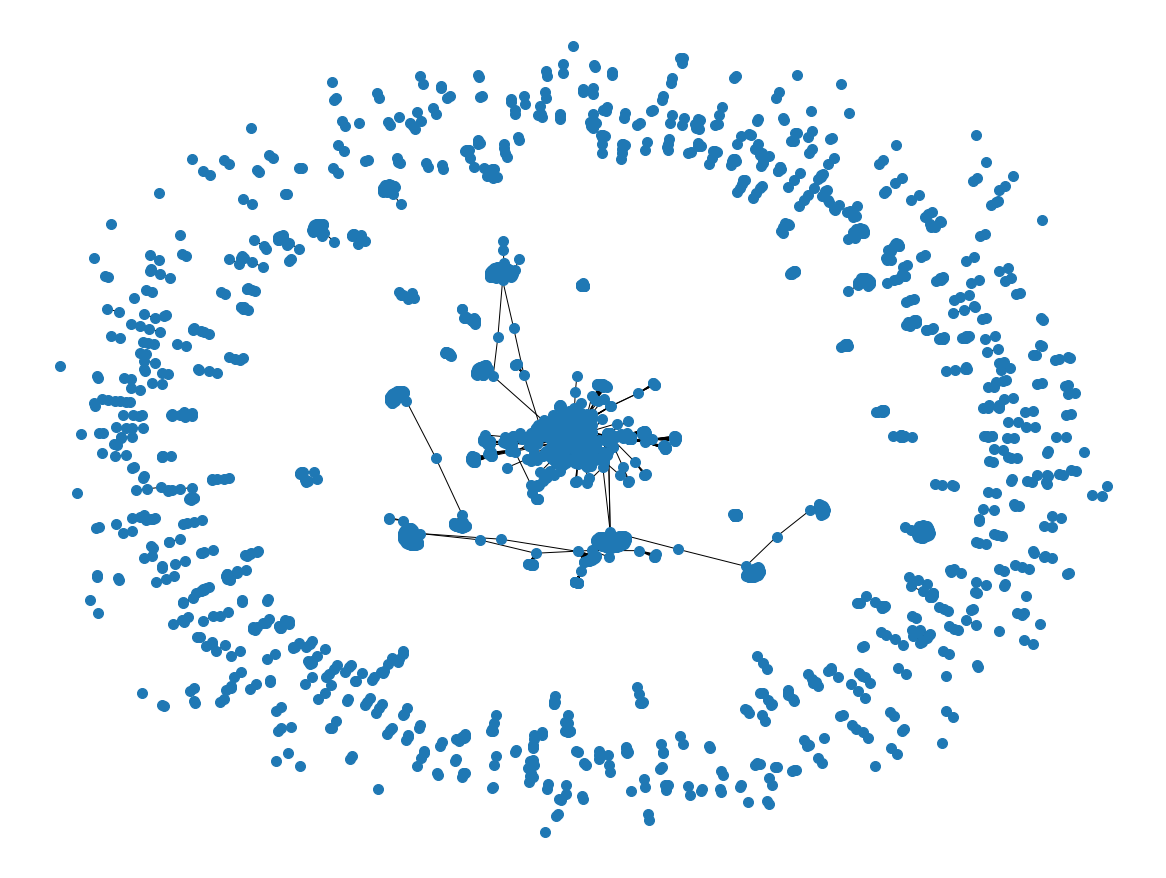

In [15]:
rhm_graph = combine_graphs([retweet_graph, hashtag_graph, mentions_graph])
print('number of nodes:', rhm_graph.number_of_nodes())
print('number of edges:', rhm_graph.number_of_edges())
vis1 = visualization(rm_graph)
vis1.create_embeddings(node2vec(vis1.train_graph, p=5, node_dim=2))
vis1.plot()
print()
vis2 = visualization(rhm_graph)
vis2.create_embeddings(node2vec(vis2.train_graph, p=5))
vis2.plot('UMAP')
print()
vis2.plot('t-SNE')
print()
vis2.plot('FD')
print()